## Занятие 8. Поиск ключевых точек и сопоставление изображений
#### Часть 3. Сопоставление с помощью нейросетей
**Алгоритм**:

0. Найти ключевые точки (КТ) на R
1. Найти ключевые КТ на Q
2. Сопоставить КТ Q и R друг-другу
3. На основе сопоставления точек найти гомографию из Q в R

Полная аналогия с пайплайном на классическом CV, но вместо классических CV-алгоритмов - нейросети. 
1. Детектор ключевых точек: SIFT -> SuperPoint
2. Матч ключевых точек: KNN -> SuperGlue

## Для работы ноутбука - должен быть склонен SuperGlue

In [1]:
### 

### 3.1 SuperPoint
[SuperPoint: Self-Supervised Interest Point Detection and Description](https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w9/DeTone_SuperPoint_Self-Supervised_Interest_CVPR_2018_paper.pdf)


In [3]:
import torch
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

BASE_PATH = Path().absolute()
assert BASE_PATH.name == 'c08'

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gpu = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu:0')
gpu = torch.device('cpu:0')
gpu

device(type='cpu', index=0)

In [8]:
cd SuperGluePretrainedNetwork/

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/classes/c08/SuperGluePretrainedNetwork


In [9]:
import matplotlib

_backend = matplotlib.get_backend()

from models.superpoint import SuperPoint
from models.utils import read_image

matplotlib.use(_backend)
%matplotlib inline


In [10]:
spoint = SuperPoint({'keypoint_threshold': 0.05}).to(gpu)

Loaded SuperPoint model


In [11]:
img1, img1_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'1.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

img2, img2_t, _ = read_image(
    BASE_PATH/ 'hpatches_tiny'/'v_bird'/'2.ppm',
    device=gpu,
    resize=(640, 480), 
    rotation=0, 
    resize_float=True
)

In [12]:
print(f"N parameters: {sum([p.numel() for p in spoint.parameters()])}")
spoint

N parameters: 1300865


SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

In [13]:
kpt1 = spoint({'image': img1_t})
kpt1.keys()

dict_keys(['keypoints', 'scores', 'descriptors'])

In [14]:
kpt1['keypoints'][0].shape, kpt1['scores'][0].shape, kpt1['descriptors'][0].shape

(torch.Size([894, 2]), torch.Size([894]), torch.Size([256, 894]))

Особенности сети
#### Итеративный NMS

In [15]:
def simple_nms(scores, nms_radius: int, iters=2):
    """ Fast Non-maximum suppression to remove nearby points """
    assert(nms_radius >= 0)

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius*2+1, stride=1, padding=nms_radius)

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(iters):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)

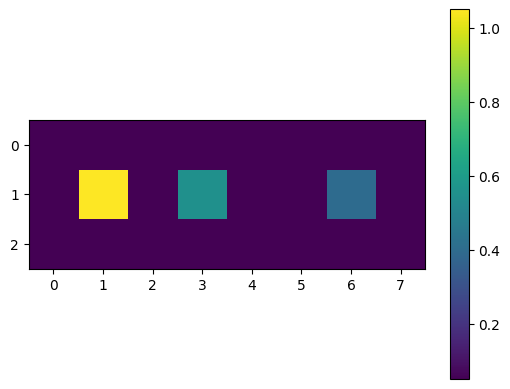

In [16]:
t = torch.tensor([
    [0, 0., 0, 0.0, 0, 0, 0.0, 0],
    [0, 1., 0, 0.5, 0, 0, 0.35, 0],
    [0, 0., 0, 0.0, 0, 0, 0.0, 0]
])[None, None] + 0.05

plt.imshow(t[0,0].numpy())
plt.colorbar()

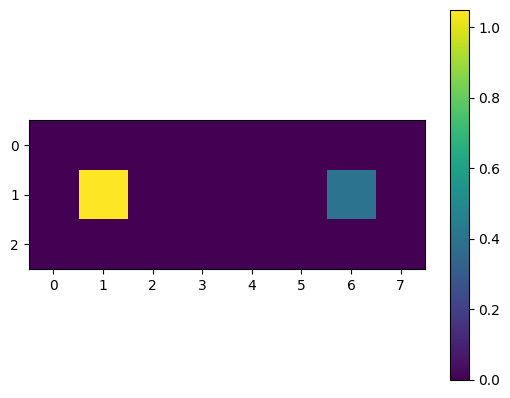

In [17]:
plt.imshow(simple_nms(t, 3, iters=2)[0,0].numpy())
plt.colorbar()

#### PixelShuffle

In [18]:
ps = torch.nn.PixelShuffle(upscale_factor=2)

In [19]:
t = torch.tensor(np.arange(2*2*3*5)).reshape((1, 4, 3, 5))
t[0,3]

tensor([[45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54],
        [55, 56, 57, 58, 59]])

In [20]:
ps(t)

tensor([[[[ 0, 15,  1, 16,  2, 17,  3, 18,  4, 19],
          [30, 45, 31, 46, 32, 47, 33, 48, 34, 49],
          [ 5, 20,  6, 21,  7, 22,  8, 23,  9, 24],
          [35, 50, 36, 51, 37, 52, 38, 53, 39, 54],
          [10, 25, 11, 26, 12, 27, 13, 28, 14, 29],
          [40, 55, 41, 56, 42, 57, 43, 58, 44, 59]]]])

### Grid Sample

/home/alexander/computerScience/phystech/9sem/abbyy/course_cvdl/.venv/lib/python3.10/site-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


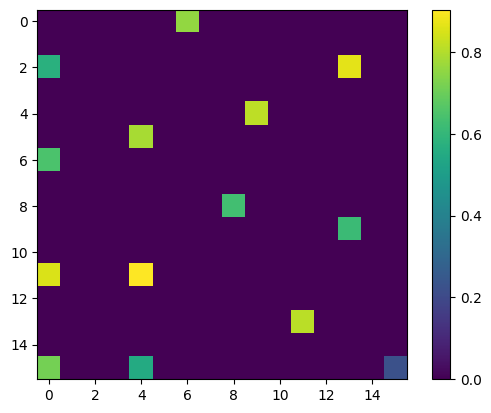

In [21]:
scores = simple_nms(
    torch.nn.functional.upsample_bilinear(torch.rand(1, 1, 8, 8), scale_factor=2),
    3
)
plt.imshow(scores[0, 0])
plt.colorbar()

torch.Size([4])
torch.Size([6, 4, 4])


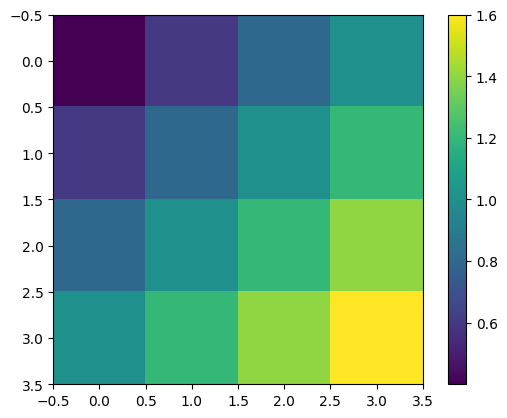

In [22]:
_d = torch.linspace(0.2, 0.8, 4)
print(_d.shape)
descriptors_2d = (_d[None, :, None] + _d[None, None, :]) * torch.ones(6)[:, None, None]
plt.imshow(descriptors_2d[1])
plt.colorbar()
print(descriptors_2d.shape)

In [23]:
keypoints = [torch.nonzero(scores[0] > 0.1)]
keypoints

[tensor([[ 0,  0,  6],
         [ 0,  2,  0],
         [ 0,  2, 13],
         [ 0,  4,  9],
         [ 0,  5,  4],
         [ 0,  6,  0],
         [ 0,  8,  8],
         [ 0,  9, 13],
         [ 0, 11,  0],
         [ 0, 11,  4],
         [ 0, 13, 11],
         [ 0, 15,  0],
         [ 0, 15,  4],
         [ 0, 15, 15]])]

In [24]:
scaled_keypoints = keypoints[0].float() 
scaled_keypoints[:,1:] /= (16 - 1)
scaled_keypoints[:, 1:] -= 0.5
scaled_keypoints[:, 1:] *= 2

scaled_keypoints

tensor([[ 0.0000, -1.0000, -0.2000],
        [ 0.0000, -0.7333, -1.0000],
        [ 0.0000, -0.7333,  0.7333],
        [ 0.0000, -0.4667,  0.2000],
        [ 0.0000, -0.3333, -0.4667],
        [ 0.0000, -0.2000, -1.0000],
        [ 0.0000,  0.0667,  0.0667],
        [ 0.0000,  0.2000,  0.7333],
        [ 0.0000,  0.4667, -1.0000],
        [ 0.0000,  0.4667, -0.4667],
        [ 0.0000,  0.7333,  0.4667],
        [ 0.0000,  1.0000, -1.0000],
        [ 0.0000,  1.0000, -0.4667],
        [ 0.0000,  1.0000,  1.0000]])

In [25]:
print(descriptors_2d.shape)

torch.Size([6, 4, 4])


In [27]:
descriptors = torch.nn.functional.grid_sample(
        descriptors_2d[None], scaled_keypoints.reshape(1, 1, -1, 2), mode='bilinear', align_corners=True
)

In [28]:
descriptors[0, :, 0, 0 ]

tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000])

### 3.2 SuperGlue
[SuperGlue: Learning Feature Matching With Graph Neural Networks](https://openaccess.thecvf.com/content_CVPR_2020/papers/Sarlin_SuperGlue_Learning_Feature_Matching_With_Graph_Neural_Networks_CVPR_2020_paper.pdf)


In [29]:
from models.superglue import SuperGlue

In [30]:
sglue = SuperGlue(config={'match_threshold': 0.5}).to(gpu)
print(f"N parameters: {sum([p.numel() for p in sglue.parameters()])}")


Loaded SuperGlue model ("indoor" weights)
N parameters: 12023297


In [31]:
sglue

SuperGlue(
  (kenc): KeypointEncoder(
    (encoder): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (gnn): AttentionalGNN(
    (layers): ModuleList(
      (0): AttentionalPropagation(
        (attn): MultiHeadedAttention(
          (merge): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    

In [32]:
kpt1 = spoint({'image': img1_t})
kpt2 = spoint({'image': img2_t})


In [33]:
sg_input = dict()
for (k, v) in kpt1.items():
    sg_input[k + '0'] = torch.stack(v, axis=0).to(gpu)

for (k, v) in kpt2.items():
    sg_input[k + '1'] = torch.stack(v, axis=0).to(gpu)
    
sg_input['image0'] = img1_t
sg_input['image1'] = img2_t

In [34]:
with torch.no_grad():
    sg_output = sglue(sg_input)
sg_output.keys()

dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1'])

In [35]:
sg_output['matches0']

tensor([[  -1,    8, 1192,   -1,   88,   -1,   26,   11,   -1,   34,   -1,   -1,
          727,   -1,   -1,  403,   -1,  558,    7,   -1,   -1,   -1,   -1,   -1,
           52,  645,   -1,   -1,   -1,   -1,   -1,   -1,   77,   46,   -1,   -1,
           21,   -1,   -1,   -1,   74,   -1,   -1,   -1,   -1,   -1,   84,   -1,
           66,   -1,   49,   -1,   -1,   -1,   -1,   23,   -1,   -1,   -1,   -1,
          105,   -1,   -1,   -1,   -1,  108,   -1,   -1,  135,   -1,   -1,   -1,
           -1,  609,   -1,   -1,   -1,  940,   89,   -1,  103,   -1,  156,   -1,
           -1,   -1,   -1,  169,  145,   -1,   -1,   -1,  114,   -1,  133,  102,
           -1,  158,  185, 1049,   -1,   -1,   94,   -1,   -1,  719,   -1,  707,
           -1,   -1,  126,  175,   -1,  166,  160,   -1,  170,   -1,  187,   -1,
           -1,  201,  192,  180,  163,  216, 1048,   -1,   -1,  223,   -1,   -1,
           -1,   -1,  202,  253,   -1,   -1,   -1,   -1,   -1,  251,   -1,   -1,
           -1,   -1,   -1,  

In [36]:
sg_output['matching_scores0']

tensor([[0.0000, 0.7184, 0.5349, 0.0000, 0.6849, 0.4735, 0.8419, 0.8851, 0.0000,
         0.9235, 0.0000, 0.0000, 0.7105, 0.3344, 0.4360, 0.5869, 0.0000, 0.5077,
         0.5915, 0.3835, 0.0000, 0.0000, 0.1754, 0.3467, 0.8825, 0.5621, 0.0000,
         0.2848, 0.0000, 0.3203, 0.0000, 0.4066, 0.8830, 0.6508, 0.3908, 0.1794,
         0.8397, 0.1194, 0.0000, 0.2767, 0.6934, 0.2819, 0.0000, 0.0000, 0.2893,
         0.0000, 0.5536, 0.0000, 0.7126, 0.0000, 0.5083, 0.2150, 0.4832, 0.2540,
         0.0000, 0.6490, 0.4994, 0.4311, 0.4177, 0.4215, 0.8725, 0.0000, 0.0000,
         0.4325, 0.0000, 0.6664, 0.1751, 0.0000, 0.7372, 0.0000, 0.4091, 0.1753,
         0.0000, 0.6369, 0.4937, 0.0000, 0.0000, 0.5519, 0.8481, 0.0000, 0.9689,
         0.0000, 0.8835, 0.4465, 0.4577, 0.4766, 0.3754, 0.9038, 0.7367, 0.2401,
         0.0000, 0.4848, 0.7314, 0.0000, 0.9321, 0.5985, 0.3320, 0.6316, 0.6976,
         0.6714, 0.0000, 0.0000, 0.6160, 0.0000, 0.4910, 0.6648, 0.3897, 0.7028,
         0.4813, 0.4990, 0.5

In [37]:
def extract_matched_keypoints(sg_in, sg_out):
    idx0 = sg_out['matches0'] > -1
    kpts0 = sg_in['keypoints0'][0][idx0[0]]
    idx1 = sg_out['matches0'][idx0]
    kpts1 = sg_in['keypoints1'][0][idx1]
    return kpts0, kpts1

kp_matched0, kp_matched1 = extract_matched_keypoints(sg_input, sg_output)
kp_matched0.shape, kp_matched1.shape

(torch.Size([355, 2]), torch.Size([355, 2]))

In [38]:
import matplotlib.cm as cm
from models.utils import make_matching_plot, make_matching_plot_fast

def show_results(sg_in, sg_out):
    img0 = sg_in['image0'].numpy().squeeze()
    img1 = sg_in['image1'].numpy().squeeze()
    
    kpts0 = sg_in['keypoints0'][0].cpu().numpy()
    kpts1 = sg_in['keypoints1'][0].cpu().numpy()
    matches = sg_out['matches0'][0].cpu().numpy()
    confidence = sg_out['matching_scores0'][0].cpu().numpy()
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])

    out = make_matching_plot_fast(
            img0, img1, kpts0, kpts1, mkpts0, mkpts1, color, "",
            path=None, show_keypoints=True, small_text=""
    )
    return out



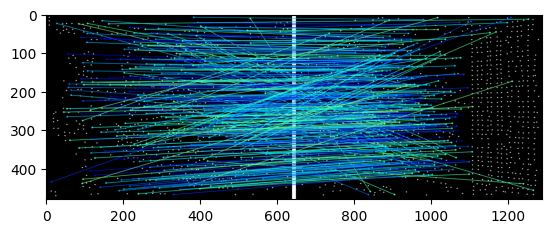

In [39]:
plt.imshow(show_results(sg_input, sg_output))

### 3.3 Sinkhorn Iterations
https://openaccess.thecvf.com/content/CVPR2022/papers/Eisenberger_A_Unified_Framework_for_Implicit_Sinkhorn_Differentiation_CVPR_2022_paper.pdf

In [40]:
from models.superglue import log_optimal_transport

In [41]:
t = (torch.randn((1, 4, 6)) - 0.5) * 5
t

tensor([[[ -1.9967,   1.1888,  -9.5221,  -1.1895,  -5.0270,  -4.6462],
         [ -2.9092, -11.3247,  -3.8407,   4.2435,   3.2722, -10.7518],
         [ -2.2185,  -7.8785,  -0.6715,  -4.6161,  -2.3596,  -3.3905],
         [ -9.3648,  -2.0213,   8.5129,  -3.6276,  -4.3584,  -4.2613]]])

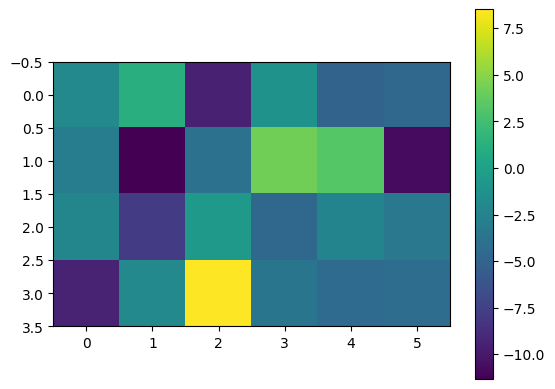

In [42]:
plt.imshow(t[0])
plt.colorbar()

In [43]:
alpha = torch.Tensor([0.0042])

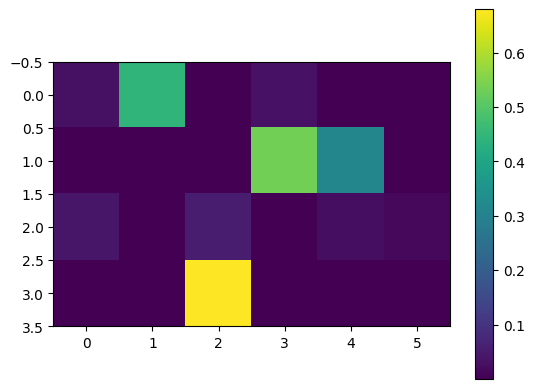

In [44]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0, :-1, :-1])
plt.colorbar()

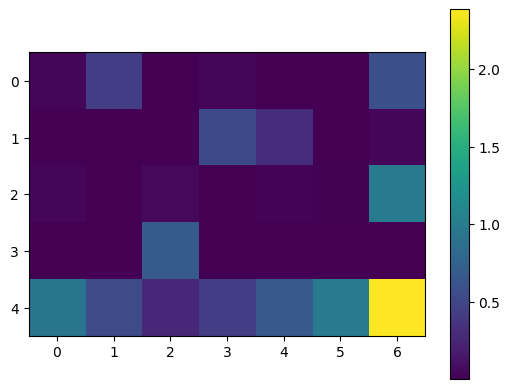

In [45]:
plt.imshow(torch.exp(log_optimal_transport(t, alpha, 2))[0])
plt.colorbar()

In [46]:
# сумма по 1 оси
# Сумма dustbin = N
torch.exp( # Матрица возводится в экспоненту!
    log_optimal_transport(t, alpha, 2)
).numpy().round(2).sum(axis=1)

array([[1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 4.  ]], dtype=float32)

In [47]:
# сумма по 2 оси
# Сумма dustbin = M
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum(axis=2)

array([[1.0999999 , 0.89000005, 1.12      , 0.68      , 6.2000003 ]],
      dtype=float32)

In [48]:
# Сумма всей матрицы
# M + N
(torch.exp(log_optimal_transport(t, alpha, 2))).numpy().round(2).sum()

9.99

In [49]:
# Результаты при 1 итерации
torch.exp(log_optimal_transport(t, alpha, 1)).numpy().round(2)

array([[[0.03, 0.45, 0.  , 0.04, 0.  , 0.  , 0.51],
        [0.  , 0.  , 0.  , 0.44, 0.23, 0.  , 0.03],
        [0.07, 0.  , 0.14, 0.  , 0.05, 0.02, 1.38],
        [0.  , 0.  , 0.47, 0.  , 0.  , 0.  , 0.  ],
        [0.9 , 0.55, 0.4 , 0.52, 0.72, 0.98, 2.08]]], dtype=float32)

In [50]:
# Результаты при 3 итерациях (разница большая с iters=1)
torch.exp(log_optimal_transport(t, alpha, 3)).numpy().round(2)

array([[[0.03, 0.43, 0.  , 0.03, 0.  , 0.  , 0.57],
        [0.  , 0.  , 0.  , 0.57, 0.35, 0.  , 0.05],
        [0.04, 0.  , 0.04, 0.  , 0.02, 0.01, 0.93],
        [0.  , 0.  , 0.77, 0.  , 0.  , 0.  , 0.  ],
        [0.93, 0.57, 0.2 , 0.4 , 0.63, 0.99, 2.45]]], dtype=float32)

In [51]:
# Результаты при 10 итерациях (разница не оч большая с iters=3)
torch.exp(log_optimal_transport(t, alpha, 10)).numpy().round(2)

array([[[0.03, 0.42, 0.  , 0.03, 0.  , 0.  , 0.54],
        [0.  , 0.  , 0.  , 0.59, 0.36, 0.  , 0.06],
        [0.04, 0.  , 0.01, 0.  , 0.02, 0.01, 0.92],
        [0.  , 0.  , 0.91, 0.  , 0.  , 0.  , 0.01],
        [0.93, 0.58, 0.07, 0.38, 0.62, 0.99, 2.48]]], dtype=float32)

### Задача-3. Используя cv2.findHomography и нейросети, напишите пайплайн нейронного матчинга

In [52]:
import cv2
SGLUE = sglue
SPOINT = spoint

In [55]:
def neural_matching_pipeline(img_Q_tensor, img_R_tensor):
    """
    Находит отображение Query в Reference, применяет его к изображению
    """
    return cv2.warpPerspective(img_Q_tensor.numpy()[0, 0], P, dsize=(img_R_tensor.shape[-1], img_R_tensor.shape[-2]))


In [56]:
plt.imshow(neural_matching_pipeline(img1_t, img2_t))

NameError: name 'P' is not defined

torch.Size([1, 1, 480, 640])


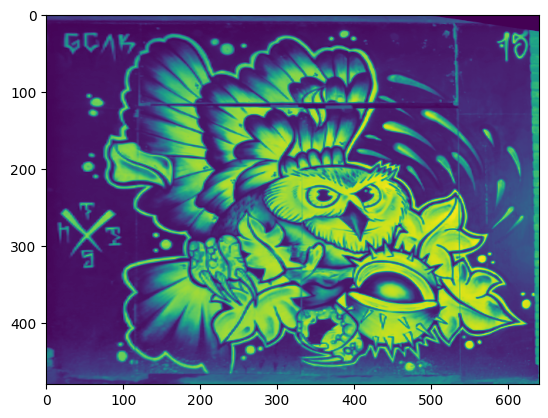

In [137]:
plt.imshow(neural_matching_pipeline(img2_t, img1_t))

### Сравнение результатов разных методов

[Image Matching Across Wide Baselines: From Paper to Practice](https://arxiv.org/pdf/2003.01587.pdf)